# Support Vector Machine Exercise
In this exercise you will learn about:
1. Implementing SVM from scratch using a sub-gradient method called Pegasos (2011)
2. The effect of imbalance and non-seperable classes on the SVM solution.
3. Pratical SVM in scikit-learn on a simple example including hyper parameter optimization wrapper class to find optimal regularization, loss and multiclass technique.
4. Optional reading material on one class, new probability interpretation of SVM

## 1. Implementing the PEGASOS SVM
We will implement the simplest SVM implementation. 
It is based on a paper by Shalev-Shwartz et al (see reading material below).
The essense of the algorithm is copied below from the paper:
![alt text](https://snag.gy/Gpi1Mk.jpg)

Here is a little more deailed explanation (it's recommended to read the full paper).
![alt_text](https://snag.gy/koA0ue.jpg)

1. Implement a class *PegasosSVM* which has parameter $\lambda$ and $T$ and methods *fit* and *predict* and *decision_function* where the latter is the distance from the plane (aka model's output score).
  * **although the above**, here you are required to pad the samples with 1, and not use bias (the separating hyperplane must go through the origin).
  * don't forget labels should be {-1,1} - change them if it is {0,1}
  * don't forget to normalize your features. You can use [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) and [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to create a pipeline which first standartize features and then learn.
  * decision function is simply the Euclidean distance (with a sign that designates from which side of the decision plane the point is located) from the decision plane to each sample. So, if you query for some point, you will get a positive number if the point is above the plain and negative if it is below it. The value will give you the distance which you can use for a scoring, for example, after you normalize it. If a point is very near to the decision plane it will have a lower score than a point that is farther. Also, if your point is located inside the margins of the model, you may want to treat the score as a probability for assigning the point to one class or another.


In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
from sklearn.base import ClassifierMixin, BaseEstimator

class PegasosSVM(ClassifierMixin, BaseEstimator):
    def __init__(self, lamb, seed=None, T=1000, k=1):
        self.lamb = lamb 
        self.T = T
        self._w = None
        self.seed = seed
        self.k = k
        
    def fit(self, X, y):
        X = self.pad(X)
        n,d = X.shape

        if self.k == 1:
            self._w = np.zeros(d)
            y = self._zero_to_minus(y)
            self._fit(X,y)
        else:
            self._w = np.zeros((d, 1))
            y = self._zero_to_minus(y).reshape((n,1))
            self._batch_fit(X,y)

        return self

    def predict(self, X):
        X = self.pad(X)
        return np.sign(X @ self._w)

    def decision_function(self, X):
        X = self.pad(X)
        return (X @ self._w) / np.linalg.norm(self._w)
    
    @staticmethod
    def pad(X):
        return np.pad(X, [(0,0), (1,0)], constant_values=1)
    
    def _sample(self, X):
        n = X.shape[0]
        rng = np.random.default_rng(self.seed)
        for _ in  range(self.T):
            yield rng.integers(n, size=self.k).squeeze()
    
    def _fit(self, X, y):
        
        for t, it in enumerate(self._sample(X), start=1):
            xit, yit = X[it], y[it]

            learning_rate = 1 / (self.lamb * t)
            is_lossy = (xit @ self._w) * yit < 1
            self._w = (1-1/(t)) * self._w + learning_rate * is_lossy * (yit * xit)

    def _batch_fit(self, X, y):
        
        for t, it in enumerate(self._sample(X), start=1):
            xit, yit = X[it], y[it]
            
            learning_rate = 1 / (self.lamb * t)
            is_lossy = (xit @ self._w) * yit < 1
            
            self._w = (1-self.lamb * learning_rate) * self._w + (learning_rate / self.k) * (is_lossy * (yit * xit)).sum()

    @staticmethod
    def _zero_to_minus(y):
        y = y.copy()
        y[y==0] = -1
        return y

2. test your class on the breast cancer database [load_breast_cancer](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html), and compare your results to the Native Scikit-learn implementation [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)
  * you can use [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)



In [3]:
from sklearn.datasets import load_breast_cancer
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

X, y =  load_breast_cancer(return_X_y=True)
y[y==0] = -1
me = make_pipeline(StandardScaler(), PegasosSVM(lamb=1/10, T=10000))
sk =  make_pipeline(StandardScaler(), LinearSVC(loss='hinge', C=1, max_iter=10000))

print(f'Mean validation score of Pegasos: {cross_val_score(me, X, y).mean()}')
print(f'Mean validation score of LinearSVC: {cross_val_score(sk, X, y).mean()}')

Mean validation score of Pegasos: 0.9771619313771154
Mean validation score of LinearSVC: 0.9718987734823784


3. Analyze the effect of the hyper parameter $\lambda$ on your training and test error. 
  * you can use scikit-learn's `validation_curve`

  >  Large values of $\lambda$ lower the learning rate, meaning we fail to learn the data thoroughly and produce a highly biased model. 
  >
  > Low values of $\lambda$ make the learning rate too high, making it hard for us to converge as our model is stochastic and it gives every point a very high significance. The problem is exacerbated by past weights shrinking in importance as the loop progresses. 
  >
  > The sweet spot is around $\frac{1}{10}$

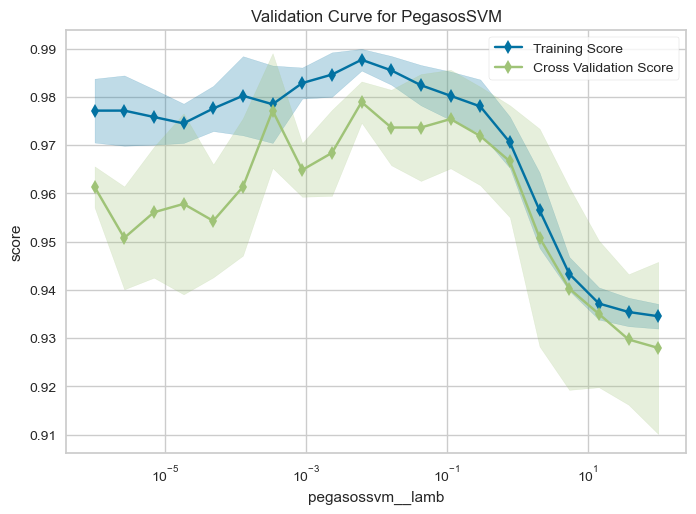

In [39]:
from yellowbrick.model_selection import validation_curve

param_range = np.logspace(-6, 2, 20)

validation_curve(me, X, y, 
                param_name="pegasossvm__lamb", 
                param_range=param_range, 
                scoring='accuracy', n_jobs=-1, logx=True, cv=5);


4. Analyze the learning curve (performance as function of training size)
  * you can use scikit-learn's `learning_curve`

  > The model's performance  on the validation set improves as we add more data to training, which makes sense as it ensures our data discribes actual trends in the data sufficiently. A very significant performance spike happens between 10%-20%. I assume it's because some key facet of the data is missing in a sample so small, making it impossible for us to generalize. 
  > 
  > Training score does not change significantly, probably because have enough iterations to fully capture the trends for a set that small. 


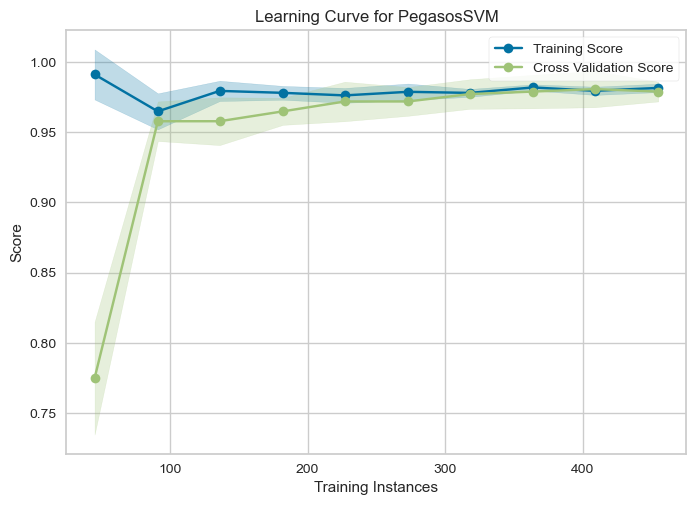

In [40]:
from yellowbrick.model_selection import learning_curve

learning_curve(me, X, y, cv=5, scoring='accuracy', 
               train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1);

5. *Bonus: Mini-batches* . In the paper, the authors summed the loss over several samples before updating. Extend your class to support mini-batches and analyze the perfomance effect if exists. See more details below
> Run time doubled for the same number of iterations and 100x sized batches.
>
> For 100x batches and 1% of iterations (same number of processed samples), computation time was 2% of stochastic.
>
> Reason for the great improvement is probably numpy's caching mechanism, which allows processing arrays much faster. 

![](https://i.ibb.co/0BGwVz7/1.png)

In [41]:
stochastic = make_pipeline(StandardScaler(), PegasosSVM(lamb=1/10, T=10000, k=1))
batch10000 = make_pipeline(StandardScaler(), PegasosSVM(lamb=1/10, T=10000, k=100))
batch100 = make_pipeline(StandardScaler(), PegasosSVM(lamb=1/10, T=100, k=100))

print('Timing or k=1, T=10000:')
%timeit stochastic.fit(X,y)
print('\nTiming for k=100, T=10000:')
%timeit batch10000.fit(X,y)
print('\nTiming for k=100, T=100:')
%timeit batch100.fit(X,y)

Timing or k=1, T=10000:
262 ms ± 15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Timing for k=100, T=10000:
533 ms ± 26.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Timing for k=100, T=100:
5.86 ms ± 78.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)



## 2. The importance of class weighting in SVM
When classes are imbalance and not seperable, SVM might result in non intuitive solution.

To see this we created for you a function `make_data` which generates a two dimensional dataset with `n_samples=1000` where a fraction `imbalance=0.1` is labeled `0` and the rest `1`. The distribution of $x$ given $y=0$ or $y=1$ is gaussian with std 0.5 or 2, respectively and that the centers are at $x_1=0$ and $x_2=-d/2$ and $x_2=d/2$, respectively. In other words,  
$$
p(x|y) = \mathcal{N}(\mu=(±d/2,0),\,\sigma=1/2+3/2\times y)
$$
and 
$$
p(y=0) = 0.1
$$. 

TODO:
1. For `d=10` and `d=2` plot the scatter plot of the data. Where would you think the SVM hyperplane will lie?
    > I think it would be impossible for svm to correctly separate the classes under d=2. And that the hyperplane would be nonsensical other than a shift to the bottom (since most of class -1 is low). 
    >
    > After checking - this is not the case. See 3. 
    >
    > For d=10, I think the decision plane would be a bordered by a line somewhere along $x_1=-2.5$

2. Now, for each of these d, draw on top of the scatter the seperation hyperplane of the built-in LinearSVC in scikit-learn.

To plot the hyperplane, note that the fitted model has the `coef_` and `intercept_` properties.
Add also the `accuracy` and the `balanced_accuracy` metrics to the plot title.

> See below.

3. repeat the experiment but now set the `class_weight` to be `balanced`. 
The "balanced" mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).

Explain what was the problem and how changing class weight solved it.
 > The problem was that the -1 class was significantly smaller than 1, and fully overlap it. Since the samples are not weighted, and no "perfect" decision boundary was possible, the model preferred to correctly classify the larger class of points and be wrong with the smaller one, making the model biased to predicting 1 to anything. That's why the adjusted accuracy is 0.5 when we don't apply class weights - one class is almost completely mis-categorized.  
 > 
 > Setting the mode to `balanced` added sample weights to counteract the small representation of -1, so that the "price" for making a mistake is "normalized" by the inverse of the class size.  

## Answer #

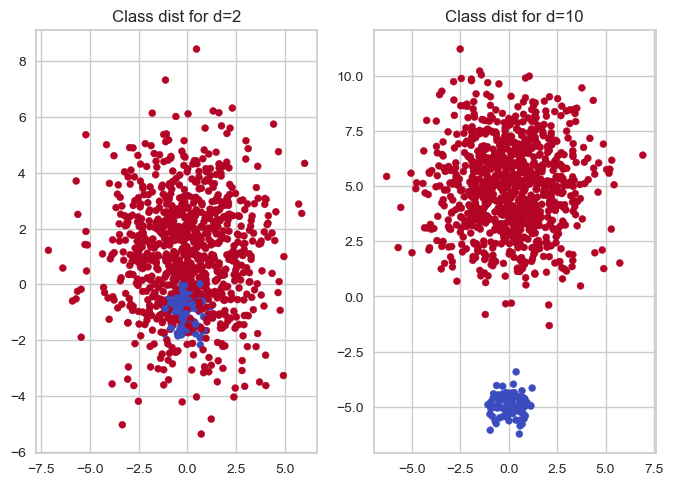

In [42]:
# a function make_data which generates a two dimensional dataset with n_samples=1000 where a fraction imbalance=0.1 is
# labeled 0 and the rest 1. The distribution of  𝑥  given  𝑦=0  or  𝑦=1  is gaussian with std 0.5 or 2, respectively and that
# the centers are at  𝑥1=0  and  𝑥2=−𝑑/2  and  𝑥2=𝑑/2 ,
from matplotlib import pyplot as plt
from sklearn.metrics import balanced_accuracy_score, accuracy_score

def make_data(d, imbalance=0.1):
    n_samples=1000
    X = np.zeros((n_samples, 2))
    y = np.random.binomial(1, 1-imbalance, n_samples)
    size_0 = np.sum(y==0)
    size_1 = np.sum(y==1)
    X[y==0,0] = np.random.normal(loc=0, scale=0.5, size=size_0)
    X[y==1,0] = np.random.normal(loc=0, scale=2, size=size_1)
    X[y==0,1] = np.random.normal(loc=-d/2, scale=0.5, size=size_0)
    X[y==1,1] = np.random.normal(loc=d/2, scale=2, size=size_1)
    return X, y

def draw_hyperplane(X, Y, clf2, ax):    
    # get the separating hyperplane
    w = clf2.named_steps['linearsvc'].coef_[0]
    a = -w[0] / w[1]

    # create a mesh to plot in
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx2, yy2 = np.meshgrid(np.arange(x_min, x_max, .2),
                        np.arange(y_min, y_max, .2))
    Z = clf2.predict(np.c_[xx2.ravel(), yy2.ravel()])

    xx = np.linspace(-x_min, x_max)
    yy = a * xx - (clf2.named_steps['linearsvc'].intercept_[0]) / w[1]

    Z = Z.reshape(xx2.shape)
    ax.contourf(xx2, yy2, Z, cmap=plt.cm.coolwarm, alpha=0.3)
    ax.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.coolwarm, s=25)

    ax.axis([x_min, x_max,y_min, y_max])


for i,d in enumerate([2,10], start=1,):

    plt.subplot(1,2,i)
    X, y = make_data(d)
    y[y==0] = -1
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=25)
    plt.title(f'Class dist for d={d}')


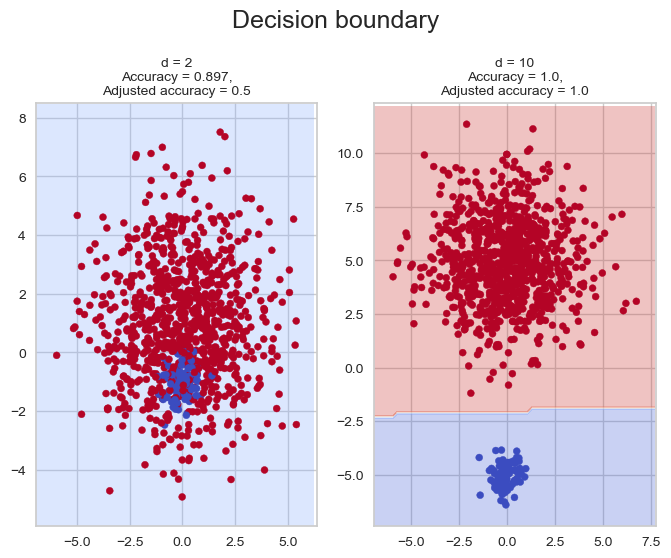

In [43]:
fig, axs = plt.subplots(1,2)
for d, ax in zip([2,10], axs):
    X, y = make_data(d)
    y[y==0] = -1
    sk.fit(X,y)
    draw_hyperplane(X,y, sk, ax=ax)
    y_pred = sk.predict(X)
    plt.suptitle(f'Decision boundary', y=1.05, fontsize=18)
    ax.set_title(f'd = {d}\nAccuracy = {accuracy_score(y, y_pred)},\nAdjusted accuracy = {balanced_accuracy_score(y, y_pred)}', fontsize=10)

plt.show()

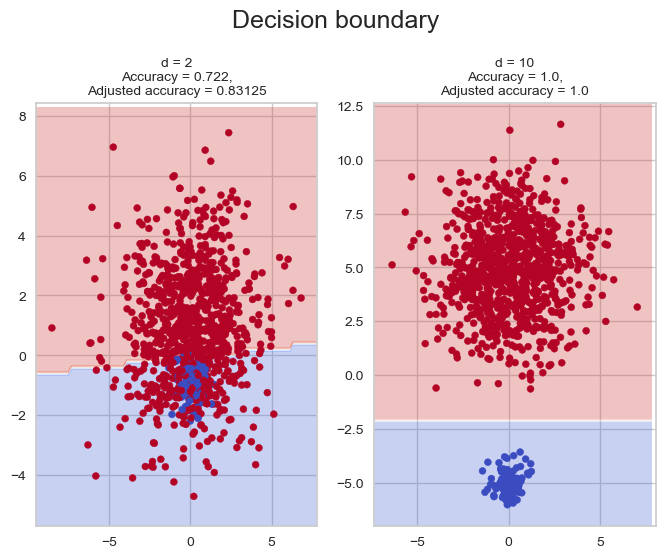

In [44]:
fig, axs = plt.subplots(1,2)

sk_balanced =  make_pipeline(StandardScaler(), LinearSVC(loss='hinge', C=1e4, max_iter=1e8, class_weight='balanced'))

for d, ax in zip([2,10], axs):
    X, y = make_data(d)
    y[y==0] = -1
    sk_balanced.fit(X,y)
    draw_hyperplane(X,y, sk_balanced, ax=ax)
    y_pred = sk_balanced.predict(X)
    plt.suptitle(f'Decision boundary', y=1.05, fontsize=18)
    ax.set_title(f'd = {d}\nAccuracy = {accuracy_score(y, y_pred)},\nAdjusted accuracy = {balanced_accuracy_score(y, y_pred)}', fontsize=10)

plt.show()

## 3. SVM hyperparameter search
Machine learning pipelines in general and models in particular has several hyperparametrs that we currently do not know how to optimize.
Instead, researcher use grid search or random search techniques to find the optimal hyper parameters.
In this exercise you are requested to compare between default params model and a model which internally optimize for these hyper parameters.
Luckily, scikit-learn already has a ready class for doing that called `GridSearchCV`. Use the latter class to check all the combination of the following hyper parameters:
* `'multi_class':['ovr', 'crammer_singer']`
* `'loss':['hinge', 'squared_hinge']`
* `'C': np.logspace(-3,3,10)`

Compare the accuracy of the model to a default `LinearSVC` model with no hyper parameter optimization in terms of accuracy.

Note: Recall, that hyper parameter search is a learning procedure by itself, thus one should not use test data for the process. 

To do this you can use the handy `cross_val_score` function.

Use the cancer dataset for this question


## Answer #

In [45]:
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

X, y =  load_breast_cancer(return_X_y=True)
y[y==0] = -1

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y)

parameters = {'multi_class':['ovr', 'crammer_singer'],
              'loss':['hinge', 'squared_hinge'],
              'C': np.logspace(-3,3,10),}

optimized = GridSearchCV(LinearSVC(), param_grid=parameters, n_jobs=-1, cv=5).fit(X_train_val, y_train_val)
accuracy_score(y_test, optimized.predict(X_test)) 


c:\Program Files\Anaconda3\envs\py4dp\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.958041958041958

In [46]:
naive = LinearSVC().fit(X_train_val, y_train_val)
accuracy_score(y_test, naive.predict(X_test))


c:\Program Files\Anaconda3\envs\py4dp\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.8251748251748252

## 4. Classifying Checkerboard with SVM (20)
In this exercise you will try to choose a kernel for classifying a checkerboard labeled data. 

* Use the `checkboard` function below to generate
your training set (1000 or 2000 samples) and a testing set (as much as you like). As you can see the function generates samples in 2D and label them according to a 3 × 3 checkerboard (obviously linear separation will not do the job here). Python’s scatter in the might come in handy.

* Use SVM to find a good linear separation in high dimensional feature space using the polynomial or the Gaussian (RBF) kernel.    You should evaluate for both models the best parameters to use. Explain how do you evalute each model?
   - For polynomial kernel, estimate which degree to use
   - For RBF, estimate which standard deviation to use
   - For both models, also choose which regularization parameter is best to use

   > I chose f1 to evaluate performance as the labels are equally important and I want to make sure my predictions are correct and comprehensive. 
 
* For the best model of each kernel, plot a scatter plot of the training patterns (colored by label) and mark the support vectors as well. Which model would you choose to use in this case?
> RBF does a much better job at categorizing the test data according to the f1 score (see below). Its support vectors also make a lot more sense, as they pretty accurately surround every square of the chess board. Poly on the other hand keeps most of the points as support vectors, and the ones that it doesn't don't keep any pattern of note, so it clearly overfits that data. 

* In addition, if you are curious, you can try and think of a way to plot the separating hyper-surface (curve in this case), the margin, and the testing set (to check which points are misclassified).

In [47]:
import numpy as np
def checkerboard(n):
    """
    CHECKERBOARD Sample points from a 3x3 checkerboard in 2D
    """
    X = np.random.rand(n,2); # samples dimension N = 2
    l = np.mod(np.ceil(X*3), 2);
    y0 = np.logical_xor(l[:,0], l[:,1])
    y = y0*2-1 # {-1,+1}
    return X, y

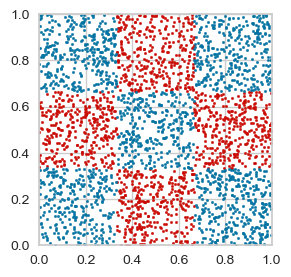

In [48]:
# Usage sample
import matplotlib.pyplot as plt
X, y = checkerboard(3000)
plt.figure(figsize=(3,3))
plt.scatter(X[y==1,0], X[y==1,1], c='r', s=3)
plt.scatter(X[y==-1,0], X[y==-1,1], c='b', s=3)
plt.xlim([0,1])
plt.ylim([0,1]);

In [49]:
def plot_checkerboard(X, y, svi=[]):
    plt.figure(figsize=(3,3))
    are_support_vectors = np.zeros_like(y, bool)
    are_support_vectors[svi] = True
    plt.scatter(X[y==1,0], X[y==1,1], c='r', s=3)
    plt.scatter(X[y==-1,0], X[y==-1,1], c='b', s=3)
    plt.scatter(X[(y==1) & are_support_vectors,0], X[(y==1) & are_support_vectors,1], c='r', s=50, marker='*', edgecolors='black', linewidths=0.7)
    plt.scatter(X[(y==-1) & are_support_vectors,0], X[(y==-1) & are_support_vectors,1], c='b', s=50, marker='*', edgecolors='black', linewidths=0.7)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.show()

In [50]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

X_train_val, y_train_val =  checkerboard(1000)

X_test, y_test = checkerboard(1000)

rbf_params = {'kernel': ['rbf'],
              'C': np.logspace(-3,3,5),
              'gamma': ['scale', 'auto']}

poly_params = {'kernel': ['poly'],
              'C': np.logspace(-3,3,5),
              'degree': np.arange(5,7),
              'gamma': ['scale', 'auto']}

rbf = GridSearchCV(SVC(), param_grid=rbf_params, n_jobs=-1, cv=2, scoring='f1').fit(X_train_val, y_train_val)
poly = GridSearchCV(SVC(), param_grid=poly_params, n_jobs=-1, cv=2, scoring='f1').fit(X_train_val, y_train_val) # too long to run

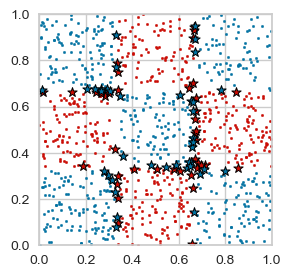

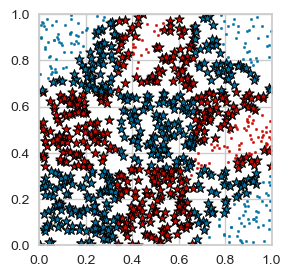

f1 score for rbf kernel: 0.98
f1 score for poly kernel: 0.71


In [51]:
from sklearn.metrics import f1_score
plot_checkerboard(X_train_val, y_train_val, rbf.best_estimator_.support_)
plot_checkerboard(X_train_val, y_train_val, poly.best_estimator_.support_)
print(f"f1 score for rbf kernel: {f1_score(y_test, rbf.predict(X_test)):.2f}")
print(f"f1 score for poly kernel: {f1_score(y_test, poly.predict(X_test)):.2f}")

## Optional Reading Materials
1. Shalev-Shwartz, S., Singer, Y., Srebro, N., & Cotter, A. (2011). Pegasos: Primal estimated sub-gradient solver for svm. Mathematical programming, 127(1), 3-30. [[pdf](http://www.ee.oulu.fi/research/imag/courses/Vedaldi/ShalevSiSr07.pdf)]

2. Schölkopf, B., Williamson, R. C., Smola, A. J., Shawe-Taylor, J., & Platt, J. C. (2000). Support vector method for novelty detection. In Advances in neural information processing systems (pp. 582-588). [[pdf](http://papers.nips.cc/paper/1723-support-vector-method-for-novelty-detection.pdf)]

3. Livni, R., Crammer, K. & Globerson, A.. (2012). A Simple Geometric Interpretation of SVM using Stochastic Adversaries. Proceedings of the Fifteenth International Conference on Artificial Intelligence and Statistics, in PMLR 22:722-730. [[pdf](http://proceedings.mlr.press/v22/livni12/livni12.pdf)]

